## Test AttentionDecoder

In [1]:
from importlib import reload

import numpy as np
import torch
import torch.nn.functional as F
from datasets.tsp import gen_fully_connected_graph
from models.decoder import AttentionDecoder
from torch_geometric.data import Batch, Data
from torch_geometric.nn import global_max_pool
from torch_geometric.utils import to_dense_batch

In [2]:
embed_dim = 4
num_heads = 2
attn = AttentionDecoder(query_dim=embed_dim, embed_dim=embed_dim, num_heads=num_heads)
attn

AttentionDecoder(
  (query_proj): Linear(in_features=4, out_features=4, bias=True)
  (key_proj): Linear(in_features=4, out_features=4, bias=True)
)

In [3]:
g1 = gen_fully_connected_graph(5)
g2 = gen_fully_connected_graph(10)
g1.mask = torch.ones((51), dtype=torch.bool)
g2.mask = torch.ones((101), dtype=torch.bool)
g1.mask[0:4] = False
g2.mask[0:4] = False
data_list = [g1 if (i % 2) == 0 else g2 for i in range(64)]

In [ ]:
batch = Batch.from_data_list(data_list)
batch

In [5]:
dense_batch = to_dense_batch(batch.x, batch.batch)[0]
dense_mask = to_dense_batch(batch.mask, batch.batch)[0]

In [6]:
key = dense_batch.permute(102)
key.shape

torch.Size([10, 64, 4])

In [7]:
mask = dense_mask.permute(021)
mask.shape

torch.Size([64, 1, 10])

In [8]:
query = global_max_pool(batch.x, batch.batch)
query = query[None, :, :]
query.shape

torch.Size([1, 64, 4])

In [9]:
attn_weight = attn(query, key, ~mask)

In [10]:
mask[0:2]

tensor([[[False, False, False, False,  True, False, False, False, False, False]],

        [[False, False, False, False,  True,  True,  True,  True,  True,  True]]])

In [11]:
attn_weight.exp()[0:2]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.1521, 0.1673, 0.1746, 0.1700,
          0.1728, 0.1631]]], grad_fn=<SliceBackward>)

In [15]:
attn_weight.exp().squeeze().multinomial(1)[0:2]

tensor([[4],
        [7]])

## Test TSP Environment

In [1]:
import torch
from datasets.tsp import gen_fully_connected_graph
from environments.tsp import TSPEnv
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_batch

In [2]:
num_nodes = 10
batch_size = 5

In [3]:
g = gen_fully_connected_graph(num_nodes)
g_list = [g for _ in range(batch_size)]
batch = Batch.from_data_list(g_list)
batch

Batch(batch=[50], edge_index=[2, 500], pos=[50, 2], x=[50, 4])

In [4]:
node_pos, dense_mask = to_dense_batch(batch.pos, batch.batch)
assert dense_mask.all()
node_pos.shape

torch.Size([5, 10, 2])

In [5]:
env = TSPEnv(node_pos)
assert env.num_nodes == num_nodes
assert env.batch_size == batch_size
print(env._avail_mask)

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


In [6]:
a = env.random_action()
env.step(a)

(TSPState(first_node=tensor([[0],
         [0],
         [0],
         [0],
         [0]]), pre_node=tensor([[9],
         [4],
         [2],
         [1],
         [8]]), avail_mask=tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [False,  True,  True,  True, False,  True,  True,  True,  True,  True],
         [False,  True, False,  True,  True,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True,  True,  True, False,  True]])),
 tensor([0., 0., 0., 0., 0.]),
 False,
 {})

In [7]:
done = False
while not done:
    state, reward, done, _ = env.step(env.random_action())
state, reward

(TSPState(first_node=tensor([[0],
         [0],
         [0],
         [0],
         [0]]), pre_node=tensor([[1],
         [5],
         [5],
         [2],
         [6]]), avail_mask=tensor([[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False]])),
 tensor([-6.7641, -6.1001, -7.0537, -6.4557, -7.4225]))

## Test TSPAgent, TSPCritic

In [1]:
from collections import namedtuple

import torch
from datasets.tsp import gen_fully_connected_graph
from environments.tsp import TSPEnv
from models.tsp_agent import TSPAgent
from models.tsp_baseline import CriticBaseline
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_batch

In [2]:
num_nodes = 10
batch_size = 64

class args:
    input_dim = 4
    embed_dim = 64
    num_embed_layers = 2
    num_gnn_layers = 2
    encoder_num_heads = 1
    decoder_num_heads = 1
    bias = True
    pooling_method = "add"
    decode_type = "sampling"
    eval_batch_size = 64
    warmup_batch_size = 256
    device = torch.device("cuda:0")
    max_grad_norm = 1.0
    tanh_clipping = 0
    normalization = "batch"

In [3]:
model = TSPAgent(args).to(args.device)

In [4]:
critic = CriticBaseline(args).to(args.device)

In [6]:
sum(param.numel() for param in critic.parameters())

36015

In [5]:
batch = Batch.from_data_list([gen_fully_connected_graph(num_nodes) for _ in range(batch_size)])
batch = batch.to(args.device)

In [6]:
node_pos = to_dense_batch(batch.pos, batch.batch)[0]
env = TSPEnv(node_pos)
env

TSP Environment, with 64 graphs of size 10

In [7]:
model.encode(batch)

Batch(batch=[640], edge_index=[2, 6400], pos=[640, 2], x=[640, 64])

In [ ]:
critic(batch)

In [8]:
log_p_s = []
selected_s = []
reward_s = []
done = False
state = env.reset(node_pos)
step = 0
while (not done) and (step < 999):
    selected, log_p = model(state)
    state, reward, done, _ = env.step(selected)
    log_p_s.append(log_p)
    selected_s.append(selected)
    reward_s.append(reward)
    step += 1

In [9]:
seqs = torch.stack(selected_s, 1)

In [10]:
logps = torch.stack(log_p_s, 1)

In [11]:
log_likelihood = logps.gather(2, seqs).squeeze().sum(1)
log_likelihood

tensor([-11.0905, -12.7257, -12.6950, -12.8495, -12.5384, -11.6274, -13.0203,
        -11.7958, -13.0039, -10.9187, -13.6919, -11.9089, -12.3686, -11.6596,
        -11.7577, -11.5274, -12.9912, -13.3216, -12.8993, -13.0036, -13.6767,
        -12.8429, -11.9340, -10.1329, -12.5332, -12.5057, -12.6261, -13.2948,
        -12.7493, -10.5740, -12.8161, -12.5921, -11.6374, -12.9641, -12.5172,
        -11.9017, -11.0072, -14.9162, -12.3361, -11.2605, -12.0295, -12.7444,
        -11.1414, -12.2185, -11.8231, -13.4235, -12.5957, -12.0204, -13.2476,
        -13.3567, -13.5189, -12.5651, -13.1168, -11.5777, -11.9570, -12.4096,
        -12.4296, -12.0215, -12.4874, -13.1155, -12.5791, -12.2565, -13.1935,
        -12.5383], device='cuda:0', grad_fn=<SumBackward1>)

In [12]:
b = model.encode(batch)

In [13]:
import torch.nn as nn
ll = logps[:, :, 1:]+0.001
ll
# loss = nn.NLLLoss()(, seqs.squeeze(-1))

tensor([[[-2.4961e+00, -2.5995e+00, -2.1859e+00,  ..., -2.6890e+00,
          -2.5081e+00, -2.2818e+00],
         [-2.1581e+00, -2.2588e+00, -1.8678e+00,  ..., -2.3331e+00,
          -2.1649e+00, -1.9922e+00],
         [-2.0446e+00, -2.1648e+00, -1.6999e+00,  ..., -2.2424e+00,
          -2.0653e+00, -1.8096e+00],
         ...,
         [-9.0324e-01, -1.1854e+00,        -inf,  ..., -1.2375e+00,
                 -inf,        -inf],
         [       -inf, -6.5951e-01,        -inf,  ..., -7.2588e-01,
                 -inf,        -inf],
         [       -inf,        -inf,        -inf,  ...,  1.0000e-03,
                 -inf,        -inf]],

        [[-2.1765e+00, -2.0970e+00, -2.3754e+00,  ..., -2.5158e+00,
          -2.2759e+00, -2.1702e+00],
         [-2.0854e+00, -1.8737e+00, -2.1889e+00,  ...,        -inf,
          -2.3247e+00, -1.9573e+00],
         [-1.8176e+00, -1.5905e+00, -2.0580e+00,  ...,        -inf,
          -2.2896e+00, -1.7264e+00],
         ...,
         [-1.0814e+00, -8

In [17]:
from torch_geometric.nn import BatchNorm
norm = BatchNorm(args.embed_dim).to(args.device)
norm(b.x.to(args.device))

tensor([[ 0.8851,  0.1003,  0.9201,  ..., -0.4026, -0.2942, -2.6055],
        [-0.1820,  0.4364, -0.9562,  ..., -0.6886, -0.9954,  0.0208],
        [ 1.4790, -0.0079,  0.4439,  ..., -1.5283, -0.6712,  1.0707],
        ...,
        [-0.8313,  1.4927,  0.0510,  ...,  0.4645, -0.9747,  0.0529],
        [-1.1597,  0.0481, -0.6940,  ...,  1.3996, -0.4882, -1.1367],
        [ 1.2771,  0.1759,  0.6788,  ..., -0.3832, -0.2091,  0.9990]],
       device='cuda:0', grad_fn=<CudnnBatchNormBackward>)

## Test Train

In [7]:
from args import get_args
from datasets.tsp import TSPDataset
from train import rollout, validate
from rl_algorithms.reinforce import _calc_log_likelihood, clip_grad_norms
from train import warmup_baseline
from tqdm import tqdm

In [9]:
dataset = TSPDataset(1000, min_num_node=num_nodes, max_num_node=num_nodes)


Processing...
Done!


In [ ]:
rollout(model, dataset, env, args)

In [46]:
validate(model, dataset, env, args)

Validating...
Validation overall avg_cost: 4.079802513122559 +- 0.02389952540397644


tensor(4.0798)

In [11]:
import torch.optim as optim
optimizer = optim.Adam(
    [{"params": model.parameters(), "lr": 0.001}] + 
    [{"params": critic.parameters(), "lr": 0.001}]
)
warmup_baseline(critic, dataset, env, optimizer, args)

  0%|          | 0/4 [00:00<?, ?it/s]

Warmup Critic Baseline with training dataset


100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


In [28]:
for i in tqdm(range(10)):
    batch = batch.to(args.device)
    model.train()
    model.encode(batch)
    model.set_decode_type("sampling")
    log_p_s = []
    selected_s = []
    reward_s = []
    done = False
    state = env.reset(to_dense_batch(batch.pos, batch.batch)[0])
    step = 0
    while (not done) and (step < 999):
        selected, log_p = model(state)
#         selected = torch.tensor([[step+1]], dtype=torch.long, device=args.device)
        state, reward, done, _ = env.step(selected)
        log_p_s.append(log_p)
        selected_s.append(selected)
        reward_s.append(reward)
        step += 1

    _log_p = torch.stack(log_p_s, 1)
    actions = torch.stack(selected_s, 1)
    log_likelihood = _calc_log_likelihood(_log_p, actions)
    reward = -reward.unsqueeze(-1)
    bl_val, bl_loss = critic.eval(batch, reward)
    rl_loss = ((reward-bl_val)*log_likelihood).mean()
    loss = rl_loss + bl_loss

    optimizer.zero_grad()
    loss.backward()
    grad_norms = clip_grad_norms(optimizer.param_groups, args.max_grad_norm)
    optimizer.step()
    

100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


In [31]:
print(len(optimizer.param_groups))

2


In [44]:
_log_p.exp().gather(2, actions).squeeze(-1)[0:8:2]

tensor([[0.1451, 0.1215, 0.1905, 0.1667, 0.1898, 0.2674, 0.3751, 0.5984, 1.0000],
        [0.1396, 0.1160, 0.0994, 0.1837, 0.2139, 0.2614, 0.3131, 0.5169, 1.0000],
        [0.1140, 0.1405, 0.1660, 0.1308, 0.2130, 0.3266, 0.3131, 0.5600, 1.0000],
        [0.1459, 0.0923, 0.1592, 0.2028, 0.2299, 0.3024, 0.3132, 0.5790, 1.0000]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [45]:
print(_log_p[0].exp())

tensor([[0.0000, 0.1039, 0.1433, 0.0961, 0.1013, 0.1098, 0.1128, 0.1124, 0.1451,
         0.0753],
        [0.0000, 0.1215, 0.1675, 0.1124, 0.1185, 0.1284, 0.1320, 0.1315, 0.0000,
         0.0881],
        [0.0000, 0.0000, 0.1905, 0.1280, 0.1349, 0.1462, 0.1502, 0.1497, 0.0000,
         0.1005],
        [0.0000, 0.0000, 0.0000, 0.1581, 0.1667, 0.1806, 0.1856, 0.1850, 0.0000,
         0.1240],
        [0.0000, 0.0000, 0.0000, 0.1898, 0.0000, 0.2167, 0.2226, 0.2219, 0.0000,
         0.1490],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2674, 0.2748, 0.2738, 0.0000,
         0.1839],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3751, 0.3739, 0.0000,
         0.2509],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5984, 0.0000,
         0.4016],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]], device='cuda:0', grad_fn=<ExpBackward>)


In [25]:
# print(reward)
# print(bl_val)


## Test MST

In [43]:
import networkx.algorithms.tree.mst as mst
from datasets.tsp import gen_fully_connected_graph
from torch_geometric.transforms import distance
from torch_geometric.utils import to_networkx, from_networkx, to_dense_batch
from torch_geometric.data import Batch

In [4]:
graph = gen_fully_connected_graph(50)
graph = Batch.from_data_list([graph] * 5)
graph

Batch(batch=[250], edge_index=[2, 12500], pos=[250, 2], x=[250, 4])

In [5]:
graph = distance.Distance(cat=False)(graph)
graph

Batch(batch=[250], edge_attr=[12500, 1], edge_index=[2, 12500], pos=[250, 2], x=[250, 4])

In [6]:
ng = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

In [7]:
ng_mst = mst.minimum_spanning_tree(ng, "edge_attr")

In [8]:
mst_len = []
for e in ng_mst.edges:
    mst_len.append(ng_mst.edges[e]["edge_attr"])

In [9]:
sum(mst_len)

20.18728230614215

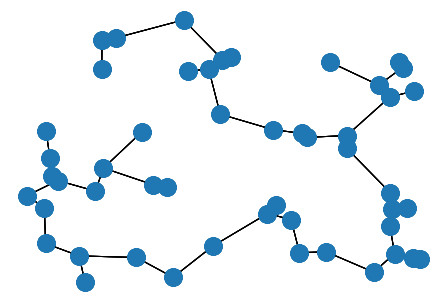

In [36]:
import networkx as nx
nx.draw(ng_mst, pos=graph.pos.numpy())
ng_mst

In [44]:
sum([edge_value["edge_attr"] for edge_value in ng_mst.edges.values()])
mst_g = from_networkx(ng_mst)
mst_b = Batch()
mst_b.batch = graph.batch
mst_b.edge_index = mst_g.edge_index
mst_b.x = graph.x
to_dense_batch(mst_b.x, mst_b.batch)

(tensor([[[0.0000, 1.0000, 0.9913, 0.1074],
          [1.0000, 0.0000, 0.1944, 0.3567],
          [1.0000, 0.0000, 0.6306, 0.5838],
          [1.0000, 0.0000, 0.8117, 0.5159],
          [1.0000, 0.0000, 0.4728, 0.8074],
          [1.0000, 0.0000, 0.9178, 0.7037],
          [1.0000, 0.0000, 0.7140, 0.5550],
          [1.0000, 0.0000, 0.9494, 0.8128],
          [1.0000, 0.0000, 0.6960, 0.1296],
          [1.0000, 0.0000, 0.2142, 0.4420],
          [1.0000, 0.0000, 0.0690, 0.2961],
          [1.0000, 0.0000, 0.3097, 0.5767],
          [1.0000, 0.0000, 0.6393, 0.3044],
          [1.0000, 0.0000, 0.2462, 0.9229],
          [1.0000, 0.0000, 0.3365, 0.3802],
          [1.0000, 0.0000, 0.1686, 0.0222],
          [1.0000, 0.0000, 0.0718, 0.1635],
          [1.0000, 0.0000, 0.9604, 0.2950],
          [1.0000, 0.0000, 0.9784, 0.7270],
          [1.0000, 0.0000, 0.9197, 0.3497],
          [1.0000, 0.0000, 0.8122, 0.5619],
          [1.0000, 0.0000, 0.2953, 0.1116],
          [1.0000, 0.0000, 0.369

## Validateto_data_listto_data_list

In [15]:
import torch
from args import get_args
from environments.tsp import TSPEnv
from models.tsp_agent import TSPAgent
from train import rollout, validate

In [16]:
args = get_args([])
args.device = torch.device("cuda")
model = TSPAgent(args).to(args.device)
model_path = "/home/pxh/TSP-experiment/outputs/tsp_50/run_20201217T165809/epoch-21.pt"
dataste_path = "/home/pxh/TSP-experiment/datasets/test/test-50-with-optimal.pk"

val_dataset = torch.load(dataste_path)
load_data = torch.load(model_path)
model.load_state_dict(load_data["model"])
env = TSPEnv()


In [17]:
out = rollout(model, val_dataset, env, args)

In [18]:
-out.sum()

tensor(1159.0975)

In [19]:
torch.sum(torch.tensor([d.len for d in val_dataset]))

tensor(569.4701)

In [20]:
1672.2463/569.4701

2.9364953489217434

In [20]:
from torch_geometric.data import Batch
b = Batch.from_data_list([val_dataset[10]]).to(args.device)


In [21]:
state = env.reset(b.pos.unsqueeze(0))
logp_s = []
done = False
while not done:
    model.eval()
    model.set_decode_type("sampling")
    model.encode(b)
    action, log_p = model(state)
    logp_s.append(log_p)
    state, r, done, _ = env.step(action)
    
-r

tensor([22.9677], device='cuda:0')

In [ ]:
for i in range(49):
#     plt.plot(torch.arange(logp_s[i].size(1)), logp_s[i].exp().detach().cpu().squeeze())
#     plt.show()
#     print(i)
#     print(logp_s[i].exp().detach().cpu().squeeze().sum())

In [29]:
import matplotlib.pyplot as plt

mst_set = torch.load('/home/pxh/TSP-experiment/datasets/test/mst-10-100-optimal.pk')

x = []
y = []
tsp = []

In [26]:
for data in mst_set:
    x.append(data.num_nodes)
    y.append((data.concorde_len / data.mst_len).item())
    tsp.append(data.concorde_len.item())

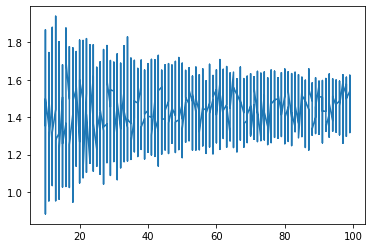

In [23]:
plt.plot(x,y)

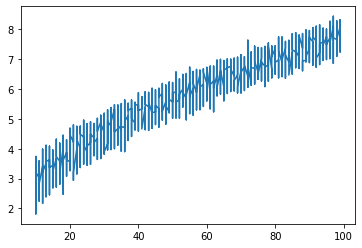

In [27]:
plt.plot(x, tsp)